In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import classification_report, r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import pickle

In [9]:
ex_df = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv')
sales_df = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_solutions.csv')

In [10]:
display(ex_df.head())
display(sales_df.head())

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday
0,7,764,4,2013-12-26,0,0,0,c,1
1,19,22,3,2013-05-22,449,1,0,0,1
2,31,1087,6,2013-06-29,622,1,0,0,0
3,45,139,6,2013-08-17,314,1,0,0,0
4,56,568,1,2014-04-07,356,1,0,0,0


,True_index,Sales
0,7,0.000000
1,19,3792.528564
2,31,5999.958008
3,45,3365.519287
4,56,3458.130127


In [11]:
df = ex_df.merge(sales_df, how='inner', on='True_index')
df

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday,Sales
0,7,764,4,2013-12-26,0,0,0,c,1,0.000000
1,19,22,3,2013-05-22,449,1,0,0,1,3792.528564
2,31,1087,6,2013-06-29,622,1,0,0,0,5999.958008
3,45,139,6,2013-08-17,314,1,0,0,0,3365.519287
4,56,568,1,2014-04-07,356,1,0,0,0,3458.130127
...,...,...,...,...,...,...,...,...,...,...
71200,712004,217,2,2015-01-13,633,1,1,0,0,5714.028320
71201,712018,604,3,2014-04-30,743,1,1,0,0,9701.739258
71202,712020,1021,5,2014-07-18,1852,1,1,0,1,15175.256836
71203,712023,28,3,2014-08-27,0,0,0,0,1,0.000000


#### Store_ID is a nominal (categorical) variable.

We should address it as such, however, there is a large number of different values, so it is a bad idea to One-Hot encode them. We created bins to group stores by the number of sales.

In [13]:
df['Store_ID'].nunique()

1115

In [14]:
df['Store_sales'] = pd.cut(df['Sales'], bins = [0, 3750, 6250, 8750, 12500, 40000], labels = ['low', 'medium', 'moderate', 'high', 'vhigh'])

Now we get dummies for Store_sales column and split into 5 new columns storing boolean values.

In [15]:
store_dummies = pd.get_dummies(df['Store_sales'], dtype = 'bool', prefix='Store')
df = pd.concat([df, store_dummies], axis=1)
df.drop(columns=['Store_ID', 'Store_sales', 'True_index'], inplace=True)

We have the same approach for the day of the week, split into 7 columns storing boolean values.

In [16]:
df['Day_of_week'].replace({1:'Monday',
                           2:'Tuesday',
                           3:'Wednesday',
                           4:'Thursday',
                           5:'Friday',
                           6:'Saturday',
                           7:'Sunday'},
                           inplace=True)
days_week_dummies = pd.get_dummies(df['Day_of_week'], dtype = 'bool')
df = pd.concat([df, days_week_dummies], axis=1)
df.drop(columns='Day_of_week', inplace=True)

C:\Users\orian\AppData\Local\Temp\ipykernel_10684\2046343609.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Day_of_week'].replace({1:'Monday',


We have the same approach for State holiday, split into 4 columns storing boolean values.

In [17]:
df['State_holiday'].replace({'0':'No_holiday',
                           'a':'Holiday_a',
                           'b':'Holiday_b',
                           'c':'Holiday_c'},
                           inplace=True)
state_holiday_dummies = pd.get_dummies(df['State_holiday'], dtype = 'bool')
df = pd.concat([df, state_holiday_dummies], axis=1)
df.drop(columns='State_holiday', inplace=True)

C:\Users\orian\AppData\Local\Temp\ipykernel_10684\829463760.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['State_holiday'].replace({'0':'No_holiday',


### Casting as correct data type

Columns storing boolean valeus should be casted as such:

In [18]:
df['Open'] = df['Open'].astype('bool')
df['Promotion'] = df['Promotion'].astype('bool')
df['School_holiday'] = df['School_holiday'].astype('bool')

Date should be casted as date type:

In [19]:
df['Date'] = pd.to_datetime(df['Date'])

Now we can extract Year, month and day from Date column

In [20]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month_name()
df['day'] = df['Date'].dt.day
df.drop(columns='Date', inplace=True)

Create dummies for year and month

In [21]:
year_dummies = pd.get_dummies(df['year'], dtype = 'bool', prefix = 'year')
df = pd.concat([df, year_dummies], axis=1)
df.drop(columns='year', inplace=True)

In [22]:
month_dummies = pd.get_dummies(df['month'], dtype = 'bool')
df = pd.concat([df, month_dummies], axis=1)
df.drop(columns='month', inplace=True)
df

,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,...,December,February,January,July,June,March,May,November,October,September
0,0,False,False,True,0.000000,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,449,True,False,True,3792.528564,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,622,True,False,False,5999.958008,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,314,True,False,False,3365.519287,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,356,True,False,False,3458.130127,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71200,633,True,True,False,5714.028320,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
71201,743,True,True,False,9701.739258,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
71202,1852,True,True,True,15175.256836,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
71203,0,False,False,True,0.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Days create 31 columns, so we take the same approach as with Store_ID. Created 3 bins to categorise days as lo, medium and high. £ columns arise from those bins

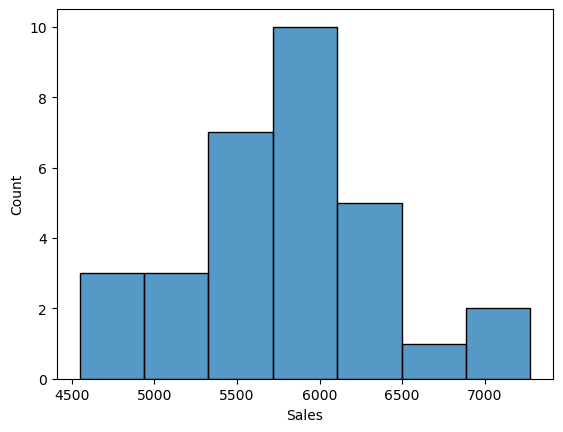

,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,0,False,False,True,0.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,449,True,False,True,3792.528564,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,622,True,False,False,5999.958008,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,314,True,False,False,3365.519287,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,356,True,False,False,3458.130127,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71200,633,True,True,False,5714.028320,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
71201,743,True,True,False,9701.739258,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
71202,1852,True,True,True,15175.256836,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True
71203,0,False,False,True,0.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
df_days = df.groupby('day')['Sales'].mean().reset_index()
sns.histplot(df_days['Sales'])
plt.show()
df['Day_sales'] = pd.cut(df['Sales'], bins = [0, 5400, 6100, 40000], labels = ['low', 'medium', 'high'])
day_dummies = pd.get_dummies(df['Day_sales'], dtype = 'bool', prefix='Day')
df = pd.concat([df, day_dummies], axis=1)
df.drop(columns=['day', 'Day_sales'], inplace=True)
df

# Creation of the first model to Classify store being OPEN or NOT

First we select the categorical columns which store the features we deem important to classify the 'opennes' of the store

In [357]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('bool')
categorical

,Open,Promotion,School_holiday,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,Friday,Monday,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,True,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,True,True,True,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,True,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,True,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,True,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640835,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
640836,True,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
640837,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
640838,True,True,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [358]:
# Decide to keep or drop categorical variables. We do that by assessing (in)dependence with the target applying Chi2 tests.
categorical_drop = []
for column in categorical.columns:
    crosstab = pd.crosstab(index=categorical['Open'], columns=categorical[column])
    chi2_p_value = chi2_contingency(crosstab)[1]
    if chi2_p_value >= 0.05:   # Variable not related, drop it
        categorical_drop.append(column)

categorical_drop    # We'll drop the columns in this list as they are concluded to not be related to the target

['year_2013', 'year_2014', 'year_2015', 'January', 'March']

Split into train and test sets

In [359]:
target = categorical['Open']
features = categorical.drop(columns=(categorical_drop + ['Open']))

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

Check for imbalanced data

Open
True     0.830185
False    0.169815
Name: proportion, dtype: float64


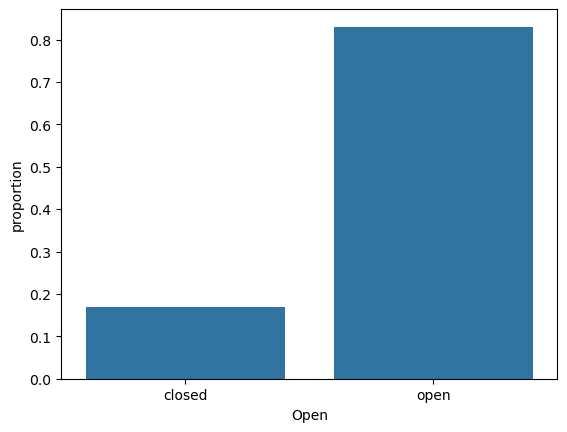

In [360]:
print(df['Open'].value_counts('normalised'))
sns.barplot(df['Open'].value_counts('normalised'))
plt.xticks([0,1], ['closed', 'open'])
plt.show()

We can see how the data is imbalanced towards open days. We have to resample, we decide to do it by SMOTE

In [364]:
## First we need to convert the data back no numerical to avoid crashing

X_train = X_train.astype('int')
y_train = y_train.astype('int')

In [365]:
smote_sampler = SMOTE()

X_train_smote, y_train_smote = smote_sampler.fit_resample(X_train, y_train)  ## resampling

In [366]:
# Choice of hyperparameters to randomise

grid = {'n_estimators' : np.arange(5,100),
        'max_depth' : np.arange(3,50),
        'max_leaf_nodes' : np.arange(5,50)}

In [367]:
estimator = GradientBoostingClassifier()  ## Choice of ensemble method
model = RandomizedSearchCV(estimator, param_distributions = grid, n_iter = 36, cv = 5, n_jobs = -1)
model.fit (X_train_smote, y_train_smote)  # trains the model

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=36,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'max_leaf_nodes': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28,..., 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

Evaluate the model

In [368]:
pred = model.best_estimator_.predict(X_test)   ## validation with test
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21578
        True       1.00      1.00      1.00    106590

    accuracy                           1.00    128168
   macro avg       1.00      1.00      1.00    128168
weighted avg       1.00      1.00      1.00    128168



In [ ]:
#pickle.dump(model.best_estimator_, open('gb_model.pkl', 'wb'))
#loaded_model = pickle.load(open('model.pkl', 'rb'))

# Creation of the second model. Regressor to predict SALES

In [371]:
## First we need to convert the data back no numerical to avoid crashing

df = df.astype('int')
display(df)
df.dtypes

,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,641,1,1,0,7293,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,877,1,1,1,7060,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,561,1,1,0,4565,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1584,1,1,0,6380,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1477,1,1,0,11647,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640835,611,1,0,0,4702,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
640836,1267,1,1,0,12545,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
640837,595,1,0,0,5823,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
640838,599,1,1,1,7986,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Nb_customers_on_day    int64
Open                   int64
Promotion              int64
School_holiday         int64
Sales                  int64
Store_low              int64
Store_medium           int64
Store_moderate         int64
Store_high             int64
Store_vhigh            int64
Friday                 int64
Monday                 int64
Saturday               int64
Sunday                 int64
Thursday               int64
Tuesday                int64
Wednesday              int64
Holiday_a              int64
Holiday_b              int64
Holiday_c              int64
No_holiday             int64
year_2013              int64
year_2014              int64
year_2015              int64
April                  int64
August                 int64
December               int64
February               int64
January                int64
July                   int64
June                   int64
March                  int64
May                    int64
November               int64
October       

Split into train and test sets

In [37]:
df_features = df.drop(columns= ['Sales', 'Open'])

In [38]:
df_features

,Nb_customers_on_day,Promotion,School_holiday,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,Friday,Monday,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,449,False,True,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,622,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,314,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,356,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71200,633,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
71201,743,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
71202,1852,True,True,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,True
71203,0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Normalise data

In [375]:
normalizer = MinMaxScaler()
normalizer.fit(X_train_reg)
X_train_norm = normalizer.transform(X_train_reg)
X_test_norm = normalizer.transform(X_test_reg)

Train the model

In [376]:
# Choice of hyperparameters to randomise

grid = {'n_estimators' : np.arange(5,100),
        'max_depth' : np.arange(3,50),
        'max_leaf_nodes' : np.arange(5,50)}

In [377]:
regressor = GradientBoostingRegressor()  ## Choice of ensemble method
model = RandomizedSearchCV(regressor, param_distributions = grid, n_iter = 36, cv = 5, n_jobs = -1)
model.fit (X_train_norm, y_train_reg)  # trains the model

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=36,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'max_leaf_nodes': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 2..., 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [ ]:
#pickle.dump(model.best_estimator_, open('gb_regressor.pkl', 'wb'))

Evaluate the model

In [381]:
pred = model.best_estimator_.predict(X_test_norm)
print('TEST DATA\n')
print(f'R2 score: ', r2_score(y_test_reg, pred))
print(f'RMSE: ', root_mean_squared_error(y_test_reg, pred))
print(f'MAE: ', mean_absolute_error(y_test_reg, pred))
print(f'\n====================================\n')
pred = model.best_estimator_.predict(X_train_norm)
print('TRAIN DATA\n')
print(f'R2 score: ', r2_score(y_train_reg, pred))
print(f'RMSE: ', root_mean_squared_error(y_train_reg, pred))
print(f'MAE: ', mean_absolute_error(y_train_reg, pred))

TEST DATA

R2 score:  0.9997880233128127
RMSE:  0.005473924218076767
MAE:  0.0002156112502768464


TRAIN DATA

R2 score:  0.9996416096549062
RMSE:  0.007105717148273332
MAE:  0.00023475325309848697


# Predictions

In [29]:
display(df)
df.dtypes

,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,0,False,False,True,0.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,449,True,False,True,3792.528564,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,622,True,False,False,5999.958008,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,314,True,False,False,3365.519287,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,356,True,False,False,3458.130127,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71200,633,True,True,False,5714.028320,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
71201,743,True,True,False,9701.739258,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
71202,1852,True,True,True,15175.256836,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True
71203,0,False,False,True,0.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Nb_customers_on_day      int64
Open                      bool
Promotion                 bool
School_holiday            bool
Sales                  float64
Store_low                 bool
Store_medium              bool
Store_moderate            bool
Store_high                bool
Store_vhigh               bool
Friday                    bool
Monday                    bool
Saturday                  bool
Sunday                    bool
Thursday                  bool
Tuesday                   bool
Wednesday                 bool
Holiday_a                 bool
Holiday_b                 bool
Holiday_c                 bool
No_holiday                bool
year_2013                 bool
year_2014                 bool
year_2015                 bool
April                     bool
August                    bool
December                  bool
February                  bool
January                   bool
July                      bool
June                      bool
March                     bool
May     

In [30]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('bool')
categorical

,Open,Promotion,School_holiday,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,Friday,Monday,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,True,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71200,True,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
71201,True,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
71202,True,True,True,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,True
71203,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
reg_model = pickle.load(open('gb_regressor_good.pkl', 'rb'))
normalizer = pickle.load(open('normalizer.pkl', 'rb'))

In [44]:
df_features_normalized = normalizer.transform(df_features)
pred_sales = reg_model.predict(df_features_normalized)
ex_df['pred_sales'] = pred_sales

solution = ex_df[['True_index','pred_sales']]
solution.to_csv('Lucie_Gaby_Arnau_solution.csv')

In [ ]:
## Forget about this

##open_model = pickle.load(open('gb_model.pkl', 'rb'))
##open_df = categorical.drop(columns=(['year_2013', 'year_2014', 'year_2015', 'January', 'March', 'Open']))
##pred_open = open_model.predict(open_df)
##sales_list = []
##sales_df = df.drop(columns= ['Sales', 'Open'])
##
##
##
##for prediction in pred_open:
##    if prediction == 1:
##        reg_model = pickle.load(open('gb_regressor.pkl', 'rb'))
##        pred_sales = reg_model.predict()
##    else:
##       sales_list.append(0)
##
##ex_df['pred_sales'] = sales_list

array([0, 1, 1, ..., 1, 0, 1])